In this notebook we shall present a simple conditional VAE, trained on MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

The conditional autoencoder will allow to generate specific digits in the MNIST range 0-9. The condition is passed as input to encoder and decoder in categorical format.

In [2]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train),28,28,1))
#The original shape is (N, 28, 28) — 2D grayscale images.
#This reshapes them to (N, 28, 28, 1) to add a channel dimension, as required by convolutional neural networks (CNNs).
x_test = x_test.reshape((len(x_test),28,28,1))
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
#This transforms the label into one-hot encoding
#3 → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
#This is essential for conditional generation, where the label is passed as an additional input (condition) to both the encoder and decoder

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
print(x_train.shape) #(60000, 28, 28, 1): there are 60000 training images in the dataset, each 28x28 pixels with only 1 channel (grayscale)
print(x_test.shape) #(10000, 28, 28, 1)
print(y_train.shape) #(60000, 10): these are the labels of the supervised set. One-hot encoding
print(y_test.shape) #(10000, 10)


(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


# The model

Sampling function for the Variational Autoencoder.
This is the clsed form of the Kullback-Leibler distance between a gaussian N(z_mean,z_var) and a normal prior N(0,1)

In [15]:
def sampling(args): #REPARAMETRIZATION TRICK z=μ+σ⋅ϵwhere ϵ∼N(0,1), σ=e^{0.5⋅log(σ^2)}
    z_mean, z_log_var = args #this is what the encoder will output
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon
    #we have to use exp to 'remove' the log from z_log_var


Main dimensions for the model (a simple stack of dense layers).

In [16]:
input_dim = (28,28,1)
latent_dim = 16

In [17]:
x = layers.Input(shape=input_dim)
c = layers.Input(shape=(10,))
cv = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(c)
cv = layers.Lambda(lambda x:tf.expand_dims(x,axis=1))(cv)
cv = layers.UpSampling2D((28,28), interpolation='nearest')(cv)
y = layers.concatenate([x,cv])
y = layers.Conv2D(16,(3,3),strides=(2,2),padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('swish')(y)
y = layers.Conv2D(16,(3,3),activation='swish',padding='same')(y)
y = layers.Conv2D(32,(3,3),strides=(2,2),activation='swish',padding='same')(y)
y = layers.Conv2D(32,(3,3),activation='swish',padding='same')(y)
y = layers.Conv2D(64,(3,3),strides=(2,2),activation='swish',padding='same')(y)
y = layers.Conv2D(64,(3,3),activation='swish',padding='same')(y)
y = layers.Flatten()(y)
y = layers.Dense(64,activation='swish')(y)
z_mean = layers.Dense(latent_dim)(y)
z_log_var = layers.Dense(latent_dim)(y)
encoder = Model([x,c],[z_mean,z_log_var])
#z_mean and z_log_var parameterize the distribution q(z∣x,c) in the latent space.

We start with the encoder. It takes two inputs: the image and the category.

It returns the latent encoding (z_mean) and a (log-)variance for each latent variable.

In [ ]:
encoder.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_16 (Lambda)        │ (None, 1, 10)          │              0 │ input_layer_33[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_17 (Lambda)        │ (None, 1, 1, 10)       │              0 │ lambda_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_32            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_5           │ (None, 28, 28, 10)     │              0 │ lambda_17[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 28, 28, 11)     │              0 │ input_layer_32[0][0],  │
│ (Concatenate)             │                        │                │ up_sampling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 14, 14, 16)     │          1,600 │ concatenate_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 14, 14, 16)     │             64 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 14, 14, 16)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 14, 14, 16)     │          2,320 │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 7, 7, 32)       │          4,640 │ conv2d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 7, 7, 32)       │          9,248 │ conv2d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 4, 4, 64)       │         18,496 │ conv2d_58[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 4, 4, 64)       │         36,928 │ conv2d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 1024)           │              0 │ conv2d_60[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 64)             │         65,600 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)     

 Total params: 140,976 (550.69 KB)

 Trainable params: 140,944 (550.56 KB)

 Non-trainable params: 32 (128.00 B)

Now we need to address the decoder. We first define its layers, in order to use them both in the vae model and in the stand-alone generator.

Now we sample around z_mean with the associated variance.

Note the use of the "lambda" layer to transform the sampling function into a keras layer.

In [18]:
#The inputs of the decoder are z (of dimension latent_dim, obviously) and c (the same one-hot encoding condition)
x = layers.Input(shape=(latent_dim,))
c = layers.Input(shape=(10,))
y = layers.concatenate([x,c])

y = layers.Dense(128,activation='swish')(y)
y = layers.concatenate([x,c])
y = layers.Dense(1024,activation='swish')(y)
y = layers.Reshape((4,4,64))(y)
y = layers.Conv2D(64,(3,3),activation='swish',padding='same')(y)
y = layers.Conv2DTranspose(32,(3,3),strides=(2,2),activation='swish',padding='same')(y)
y = layers.Conv2D(32,(3,3),activation='swish',padding='same')(y)
y = layers.Conv2DTranspose(16,(3,3),strides=(2,2),activation='swish',padding='same')(y)
y = layers.Conv2D(16,(3,3),activation='swish',padding='valid')(y)
y = layers.Conv2DTranspose(16,(3,3),strides=(2,2),activation='swish',padding='same')(y)
y = layers.Conv2D(16,(3,3),padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('swish')(y)
y = layers.Conv2D(1,(3,3),activation='sigmoid',padding='same')(y)
decoder = Model([x,c],y) #the decoder model takes in input z and c and returns an image y
#decoder = Model(x,y)

In [19]:
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 26)        │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1024)      │     27,648 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4, 64)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 32)  │     18,464 │ conv2d_6[0][0]    │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 32)  │      9,248 │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │      4,624 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │      2,320 │ conv2d_transpose… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 28, 28,    │      2,320 │ conv2d_8[0][0]    │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │      2,320 │ conv2d_transpose… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28, 1) │        145 │ activation_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 104,081 (406.57 KB)

 Trainable params: 104,049 (406.44 KB)

 Non-trainable params: 32 (128.00 B)

In [21]:
class KLDivergenceLayer(layers.Layer):
    """
    Custom Keras layer to calculate the KL divergence loss.

    This layer ensures that the KL divergence calculation is performed
    on concrete tensors during model execution, avoiding the error
    "ValueError: Tried to convert 'x' to a tensor and failed."
    """
    def __init__(self, gamma=0.0001, **kwargs):
        super(KLDivergenceLayer, self).__init__(**kwargs)
        self.gamma = gamma

    def call(self, inputs):
        z_mean, z_log_var = inputs
        # Calculate KL divergence loss
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        # Apply gamma scaling
        kl_loss = self.gamma * kl_loss
        # Add the KL loss as an activity regularization loss
        self.add_loss(K.mean(kl_loss))
        # Return the original inputs unchanged
        return inputs

Now, the the following code defines the structure and functionality of the Conditional Variational Autoencoder (CVAE). It connects the encoder, decoder, and sampling process to create a model that can generate images based on specific conditions (in this case, MNIST digit categories).

In [22]:
x = layers.Input(shape=input_dim)
c = layers.Input(shape=(10,))
z_mean, z_log_var = encoder([x,c])
z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_hat = decoder([z,c]) #z
cvae = Model([x,c],x_hat)

In [23]:
cvae.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 16),      │    140,976 │ input_layer_4[0]… │
│ (Functional)        │ (None, 16)]       │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_divergence_layer │ [(None, 16),      │          0 │ functional[0][0], │
│ (KLDivergenceLayer) │ (None, 16)]       │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 16)        │          0 │ kl_divergence_la… │
│                     │                   │            │ kl_divergence_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 28, 28, 1) │    104,081 │ lambda_2[0][0],   │
│ (Functional)        │                   │            │ input_layer_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 245,057 (957.25 KB)

 Trainable params: 244,993 (957.00 KB)

 Non-trainable params: 64 (256.00 B)

We decode the image starting from the latent representation z and its category y, that must be concatenated.

The VAE loss function is just the sum between the reconstruction error (mse or bce) and the KL-divergence, acting as a regularizer of the latent space.

In [24]:
def vae_loss(y_true, y_pred):
    gamma = .0001  #balancing parameter
    # Reconstruction loss
    rec_loss = K.sum(metrics.mse(y_true, y_pred),axis=(1,2))
    # KL divergence loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # Total VAE loss
    total_loss = rec_loss + gamma*kl_loss
    return total_loss

Some hyperparameters. Gamma is used to balance loglikelihood and KL-divergence in the loss function

In [25]:
batch_size = 128
epochs = 60

We are ready to compile. There is no need to specify the loss function, since we already added it to the model with add_loss.

In [26]:
optimizer = optimizers.Adam(learning_rate=.0005)

In [27]:
cvae.compile(optimizer=optimizer,loss='mse')

Train for a sufficient amount of epochs. Generation is a more complex task than classification.

In [28]:
cvae.fit([x_train,y_train],x_train,epochs=30,batch_size=batch_size)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 0.1100
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0226
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0172
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0154
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0144
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0136
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0131
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0127
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0124
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0121
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0119
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0116
Epoch 13/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0114
Epoch 14/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0113
Epoch 15/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - 

Let us decode the full test set.

In [29]:
decoded_imgs = cvae.predict([x_test,y_test])

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


The following function is to test the quality of reconstructions (not particularly good, since compression is strong).

In [30]:
def plot(n=10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

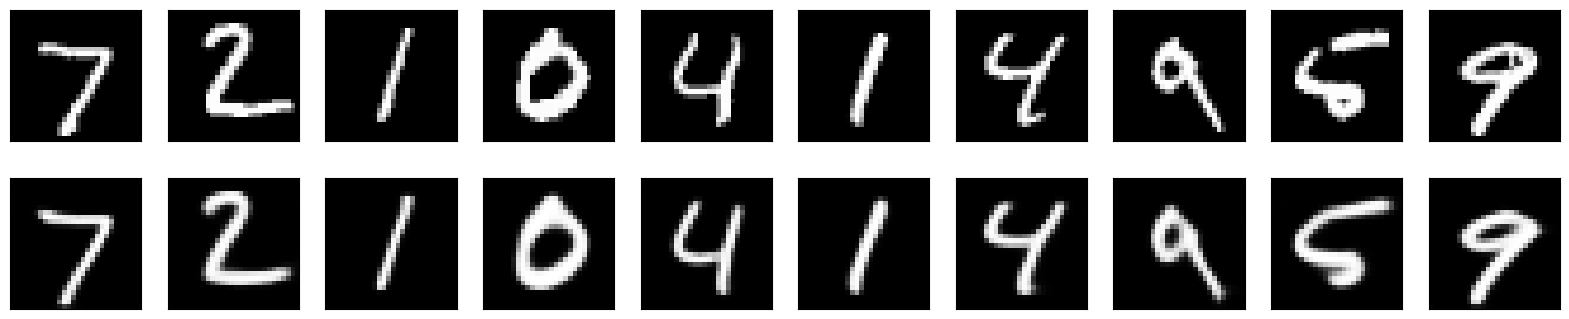

In [31]:
plot()

Finally, we build a digit generator that can sample from the learned distribution

In [32]:
generator = decoder
# It helps clarify intent. While "decoder" emphasizes its role inside the autoencoder architecture, "generator" emphasizes its independent usage:
# generating new data given a latent vector z and a condition c (a digit label in this case).

And we can generate our samples

input digit to generate: 
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


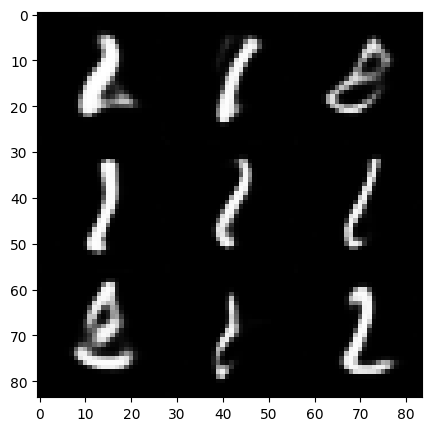

input digit to generate: 
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


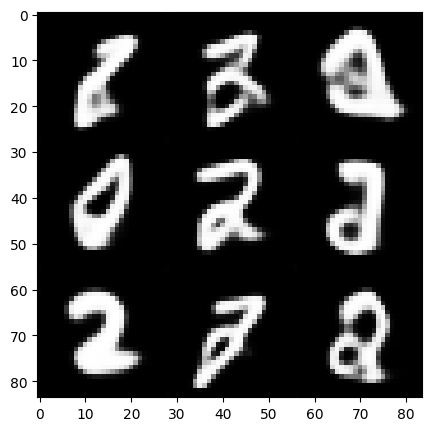

input digit to generate: 
-1
-1


In [36]:
import time
# display a 2D manifold of the digits
n = 3
digit_size = 28 # figure with 15x15 digits
figure = np.zeros((digit_size * n, digit_size * n))

while True:
  label = input("input digit to generate: \n")
  label = int(label)
  if label < 0 or label > 9:
      print(label)
      break
  label = np.expand_dims(utils.to_categorical(label,10),axis=0)
  for i in range(0,n):
    for j in range (0,n):
        z_sample = np.expand_dims(np.random.normal(size=latent_dim),axis=0)
        x_decoded = generator.predict([z_sample,label])
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
  plt.figure(figsize=(5, 5))
  plt.imshow(figure, cmap='Greys_r')
  plt.show()
  time.sleep(1)


Differenza chiave rispetto a un VAE standard

- **VAE** normale: lo spazio latente z deve codificare tutto (sia la cifra che lo stile).
Senza c, due z vicini potrebbero corrispondere a cifre diverse (es.un "3" e un "8" simili).

- **CVAE**: z codifica solo lo stile, mentre c gestisce la classe.
Risultato: Più controllo e spazio latente meglio organizzato.